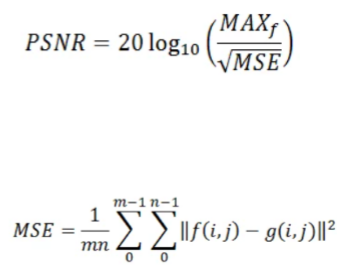

where,<br>
MAXf = maximum signal value that exists in our original image<br>
g = Ground truth image<br>
f = Noisy image<br>
m = no of rows of pixels and i represents the index of that row.<br>
n = no of columns of pixels and j represents the index of that column

#Dataset Overview


RENOIR Dataset :- A Dataset for Real Low-Light Image Noise Reduction.<br>
We will take 221 clean-noisy image pairs from this dataset 

In [1]:
!pip install patchify

In [2]:
#Importing relevant libraries
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
%load_ext tensorboard

##Extracting Image paths for SIDD Dataset

##Extracting Image paths for RENOIR Dataset

In [3]:
df = pd.DataFrame()
dir = os.listdir('/kaggle/input/renoir/GroundTruth')
GT = []
Nsy=[]
for image in dir:
  GT.append('/kaggle/input/renoir/GroundTruth/'+image)

dir = os.listdir('/kaggle/input/renoir/Noisy')
for image in dir:
  Nsy.append('/kaggle/input/renoir/Noisy/'+image)

df['Ground Truth Images'] = GT
df['Noisy Images'] = Nsy
df.head()

Ground Truth Images  \
0  /kaggle/input/renoir/GroundTruth/129.bmp   
1  /kaggle/input/renoir/GroundTruth/184.bmp   
2   /kaggle/input/renoir/GroundTruth/65.bmp   
3  /kaggle/input/renoir/GroundTruth/209.bmp   
4  /kaggle/input/renoir/GroundTruth/133.bmp   

                         Noisy Images  
0  /kaggle/input/renoir/Noisy/129.bmp  
1  /kaggle/input/renoir/Noisy/184.bmp  
2   /kaggle/input/renoir/Noisy/65.bmp  
3  /kaggle/input/renoir/Noisy/209.bmp  
4  /kaggle/input/renoir/Noisy/133.bmp

In [4]:
df.shape

(221, 2)

#Exploratory Data Analysis

##Image Sizes

In [5]:
size=[]
for i in range(len(df)):
  img_gt = cv2.imread(df['Ground Truth Images'].iloc[i])
  size.append(img_gt.shape)

In [6]:
df['image size'] = size
df['image size'] = df['image size'].astype(str)
df.head()

Ground Truth Images  \
0  /kaggle/input/renoir/GroundTruth/129.bmp   
1  /kaggle/input/renoir/GroundTruth/184.bmp   
2   /kaggle/input/renoir/GroundTruth/65.bmp   
3  /kaggle/input/renoir/GroundTruth/209.bmp   
4  /kaggle/input/renoir/GroundTruth/133.bmp   

                         Noisy Images       image size  
0  /kaggle/input/renoir/Noisy/129.bmp  (2760, 3684, 3)  
1  /kaggle/input/renoir/Noisy/184.bmp  (3465, 5197, 3)  
2   /kaggle/input/renoir/Noisy/65.bmp  (3000, 3000, 3)  
3  /kaggle/input/renoir/Noisy/209.bmp  (3465, 5199, 3)  
4  /kaggle/input/renoir/Noisy/133.bmp  (2760, 3684, 3)

Text(0, 0.5, 'No. of images')

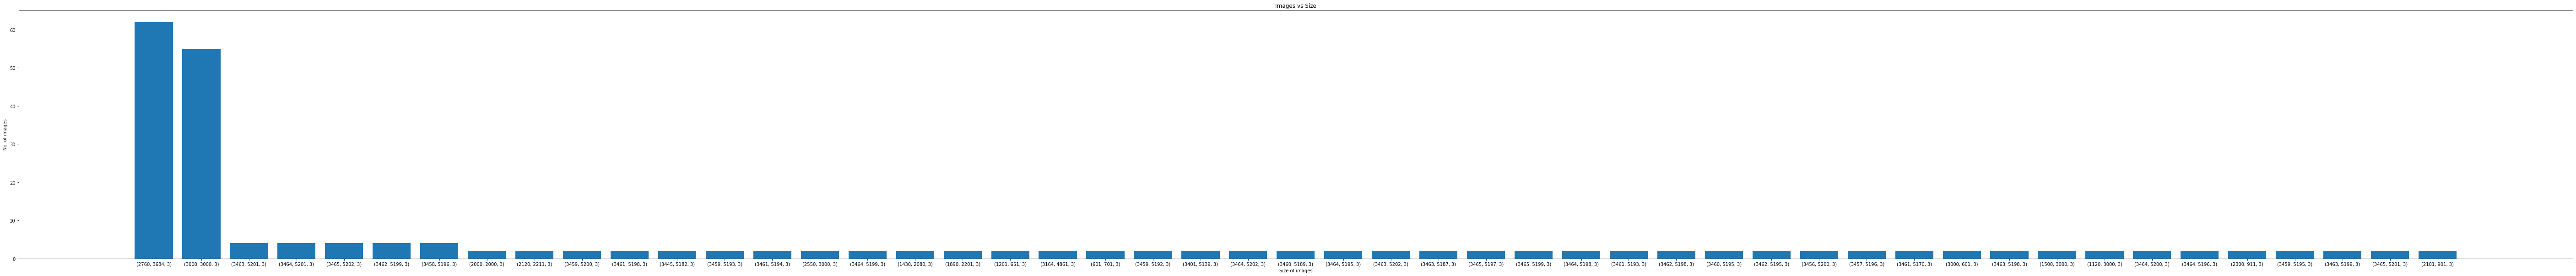

In [7]:
fig = plt.figure(figsize = (100, 10))
y = list(df['image size'].value_counts())
x = df['image size'].value_counts().index.tolist()
plt.bar(x,y)
plt.title("Images vs Size")
plt.xlabel("Size of images")
plt.ylabel("No. of images")

Observation : Most number of images have size (3024 x 4032).

##Displaying few clean-noisy image pairs

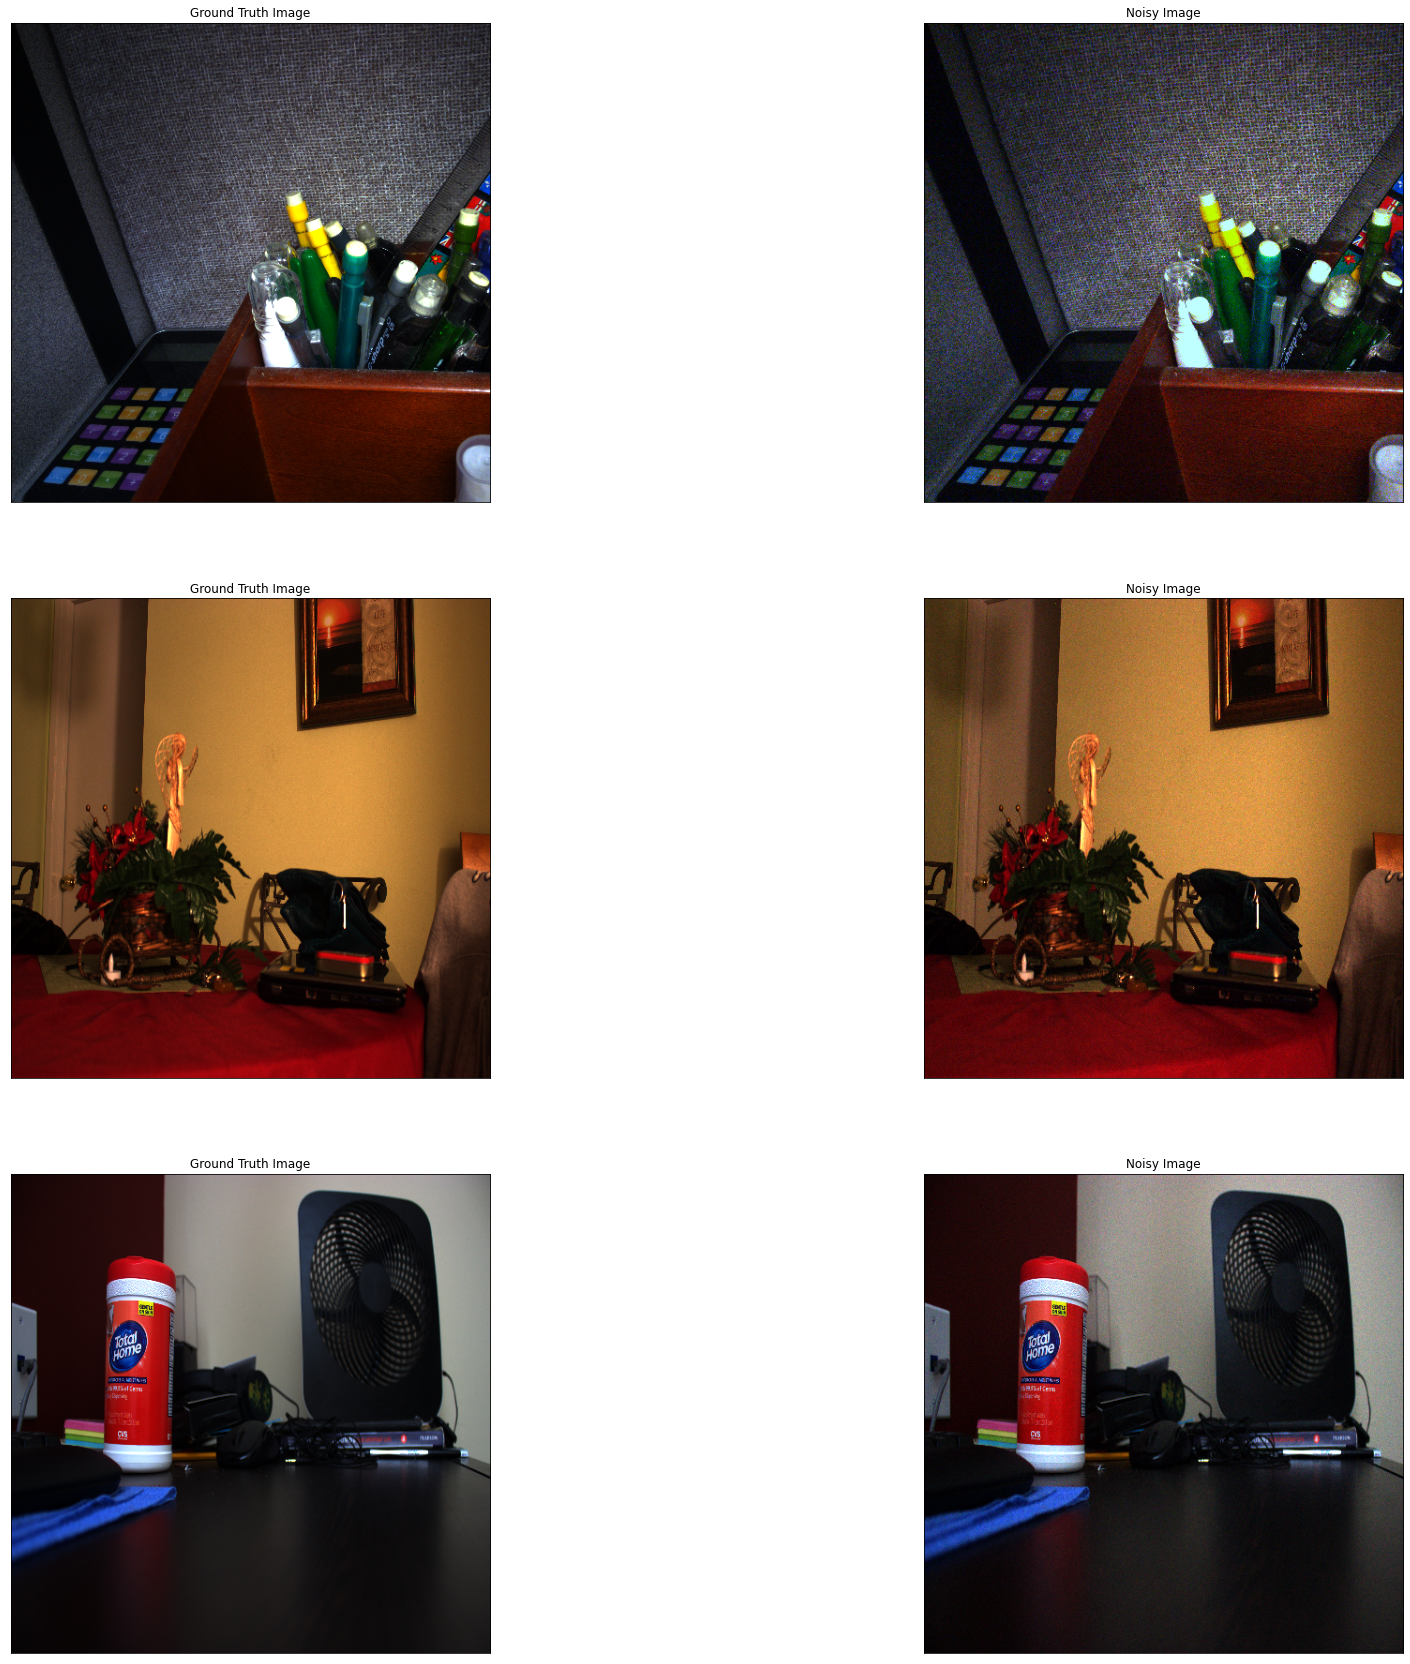

In [8]:
sample = df.sample(3)
fig, ax = plt.subplots(len(sample),2,figsize=(30,30))
for i in range(len(sample)):
  img = cv2.imread(sample['Ground Truth Images'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][0].imshow(img)
  ax[i][0].get_xaxis().set_visible(False)
  ax[i][0].get_yaxis().set_visible(False)
  ax[i][0].title.set_text("Ground Truth Image")
  
  img = cv2.imread(sample['Noisy Images'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][1].imshow(img)
  ax[i][1].get_xaxis().set_visible(False)
  ax[i][1].get_yaxis().set_visible(False)
  ax[i][1].title.set_text("Noisy Image")

Observation : One can see, there is significant amount of noise in the nosiy images and the ground truth images shows the corresponding clean images free from noise. <br>


##Splitting the dataset into train and test datasets

In [9]:
X = df['Noisy Images']
y = df['Ground Truth Images']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open('train_path.pkl','wb'))
pickle.dump((X_test,y_test),open('test_path.pkl','wb'))

In [11]:
X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test,y_test = pickle.load(open('test_path.pkl', 'rb'))

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(176,)
(176,)
(45,)
(45,)


##Creating Patches

In [13]:
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [14]:
sample = pd.DataFrame({'Ground Truth Images':['a','/kaggle/input/renoir/GroundTruth/0.bmp'], 'Noisy Images':['b','/kaggle/input/renoir/Noisy/0.bmp']})
sample

Ground Truth Images                      Noisy Images
0                                       a                                 b
1  /kaggle/input/renoir/GroundTruth/0.bmp  /kaggle/input/renoir/Noisy/0.bmp

In [15]:
#Creating patches for a Ground Truth Image
path = sample['Ground Truth Images'].iloc[1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_gt = patches(img,256)
print('Patch shape: {}'.format(patches_gt.shape))

Image shape: (3000, 3000, 3)
Patch shape: (11, 11, 1, 256, 256, 3)


In [16]:
#Creating patches for a Noisy Image
path = sample['Noisy Images'].iloc[1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,256)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (3000, 3000, 3)
Patch shape: (11, 11, 1, 256, 256, 3)


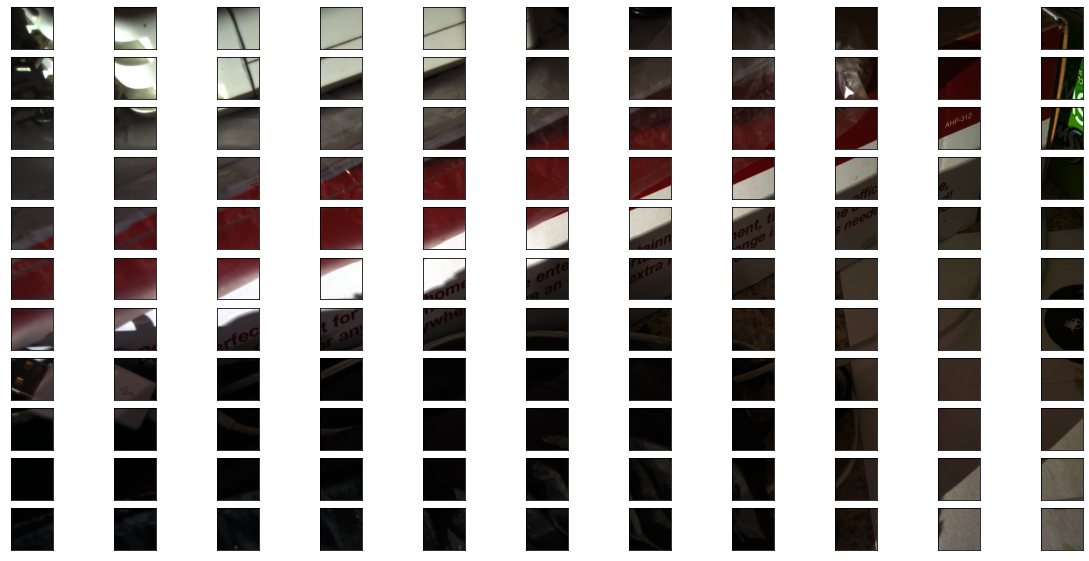

In [17]:
rows = patches_nsy.shape[0]
cols = patches_nsy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)

This is what patches does. It splits the images into different patches based on a given patch size.

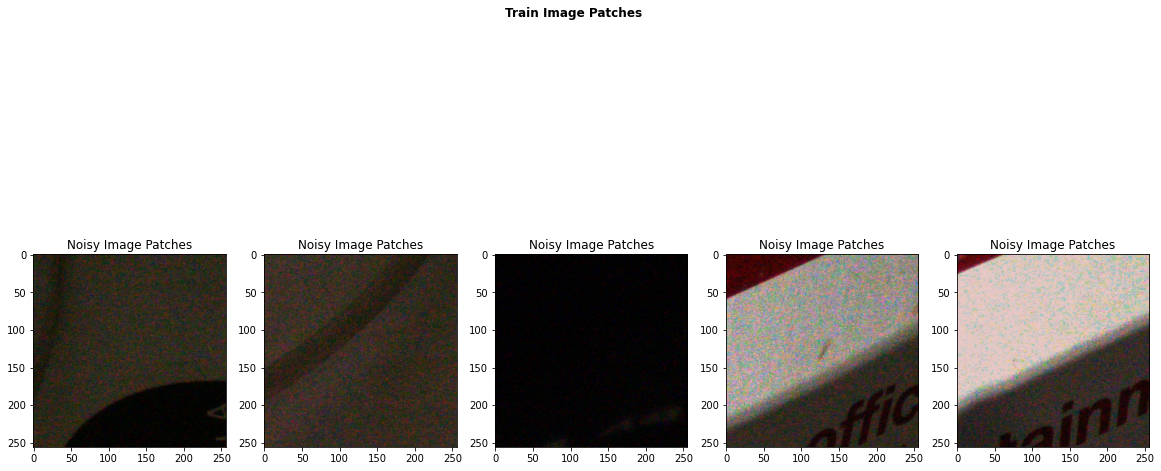

In [18]:
fig, axs = plt.subplots(1,5,figsize=(20,10))
r = random.sample(range(0, rows), 5)
c = random.sample(range(0, cols), 5)
fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[i].imshow(patches_gt[r[i]][c[i]][0])
  axs[i].set_title('Ground Truth Image Patches')
  axs[i].imshow(patches_nsy[r[i]][c[i]][0])
  axs[i].set_title('Noisy Image Patches')


We can clearly see the difference between ground truth image patches and noisy image patches. There is significant amount on noisy in the noisy image patches and this is what we are trying to remove. <br>

We will be creating patches for all the images. Experiments have shown that splitting images into patches and using these patches for training improve model performance in denoising. In regard to that, we will resize all the images to a fixed size of 1024 x 1024 and create patches with patch size 256 x 256.

In [19]:
#Creating patches for X_train and y_train
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)
  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])
  
X_train = np.array(X_train_patches)
y_train = np.array(y_train_patches)

In [20]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)
  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test = np.array(X_test_patches)
y_test = np.array(y_test_patches)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2816, 256, 256, 3)
(2816, 256, 256, 3)
(720, 256, 256, 3)
(720, 256, 256, 3)


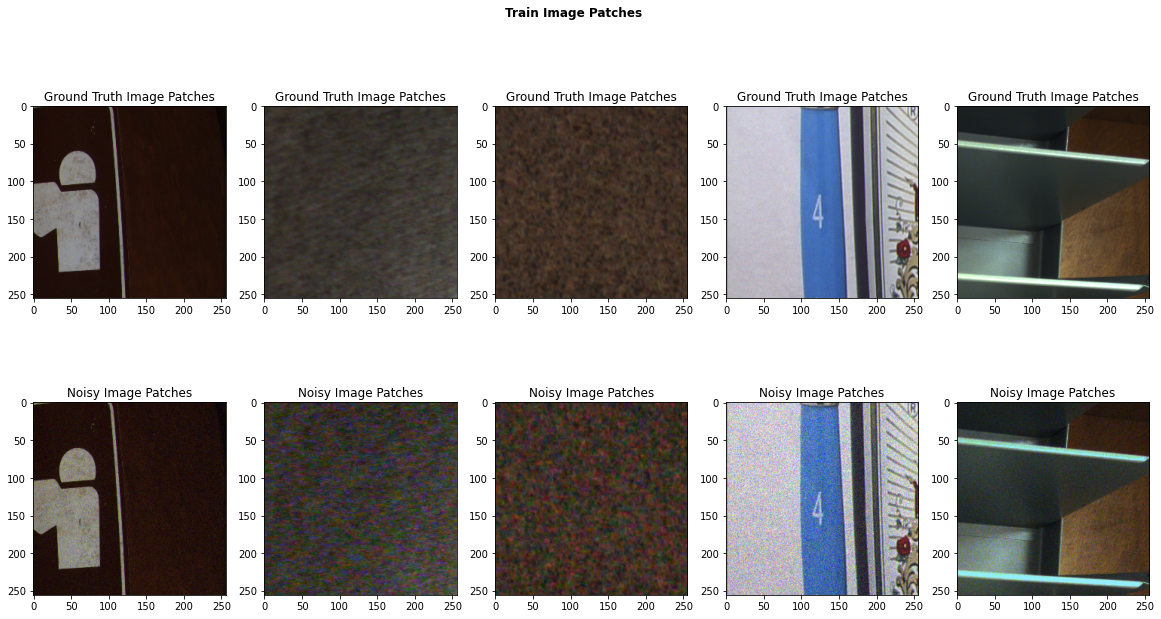

In [22]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, 2816), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

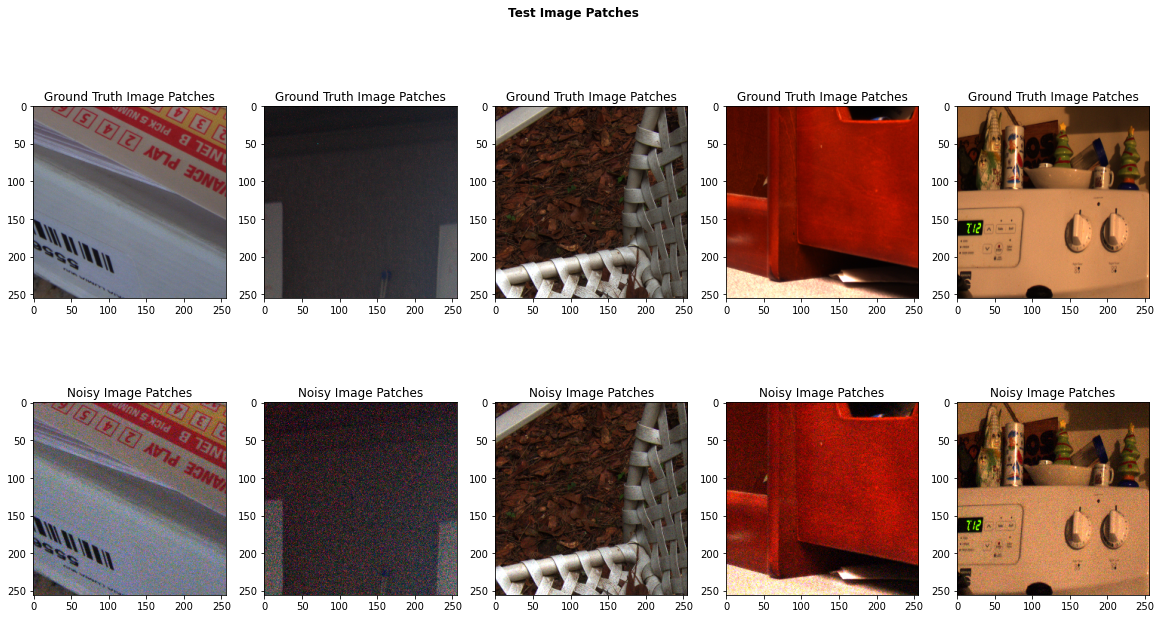

In [23]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, 720), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [24]:
print("Total number of image patches on train data : ", len(X_train))
print("Total number of image patches on test data : ", len(X_test))

Total number of image patches on train data :  2816
Total number of image patches on test data :  720


After creating image patches, there are a total of 2816 image patches in train dataset and 720 image patches in test dataset.

In [25]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open('train_data.pkl','wb'))
pickle.dump((X_test,y_test),open('test_data.pkl','wb'))

In [26]:
X_train_patches, y_train_patches = pickle.load(open('train_data.pkl', 'rb'))
X_test_patches,y_test_patches = pickle.load(open('test_data.pkl', 'rb'))

In [27]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(2816, 256, 256, 3)
(2816, 256, 256, 3)
(720, 256, 256, 3)
(720, 256, 256, 3)


In [28]:
#Normalizing the image pixels
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [29]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [30]:
batch_size=32
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)

In [31]:
train_dataloader[0][0].shape

(32, 256, 256, 3)

#Some plotting and prediction functions that can be used for all model

In [32]:
#Custom function to get denoised image prediction for noisy images
def prediction(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)

  pred_img = model.predict(nsy)
  pred_img = np.reshape(pred_img,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [33]:
#Custom function to get denoised image prediction for noisy images on quantized models using tflite
def prediction_tflite(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)
  pred=[]
  for patch in nsy:
    model.set_tensor(input_details[0]['index'], tf.expand_dims(patch,axis=0))
    model.invoke()
    tflite_model_predictions = model.get_tensor(output_details[0]['index'])
    pred.append(tflite_model_predictions)

  pred_img = np.reshape(pred,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [34]:
#Custom function to plot/visualize noisy, ground truth and predicted images
def visualize(sample,model):
  fig,ax = plt.subplots(len(sample),3,figsize=(30,30))
  for i in range(len(sample)):
    path = sample['Ground Truth Images'].iloc[i]
    test_img_gt = cv2.imread(path)
    test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
    test_img_gt = cv2.resize(test_img_gt,(512,512))
    test_img_gt = test_img_gt.astype("float32") / 255.0
  
    path = sample['Noisy Images'].iloc[i]
    test_img_nsy = cv2.imread(path)
    pred_img = prediction(test_img_nsy,model)
    pred_img = cv2.resize(pred_img,(512,512))

    test_img_nsy = cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
    test_img_nsy = cv2.resize(test_img_nsy,(512,512))
    test_img_nsy = test_img_nsy.astype("float32") / 255.0
    
    ax[i][0].imshow(test_img_nsy)
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][0].title.set_text("Noisy Image")

    ax[i][1].imshow(test_img_gt)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    ax[i][1].title.set_text("Ground Truth Image")

    ax[i][2].imshow(pred_img)
    ax[i][2].get_xaxis().set_visible(False)
    ax[i][2].get_yaxis().set_visible(False)
    ax[i][2].title.set_text("Predicted Image")

In [35]:
#Custom function that computes the psnr and ssim values for images
def psnr_and_ssim(X_test,y_test,model,model_type='Normal'):
  psnr_nsy = 0.0
  psnr_de_nsy = 0.0
  ssim_nsy = 0.0
  ssim_de_nsy = 0.0
  for i in range(len(X_test)):
    #getting the noisy images
    path = X_test.iloc[i]
    nsy = cv2.imread(path)  

    #getting the predicted images
    if model_type == 'Quantized': 
      pred = prediction_tflite(nsy,model)
    else:
      pred = prediction(nsy,model)

    #getting the ground truth images
    path = y_test.iloc[i]
    gt = cv2.imread(path)         
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    
    #Resizing the images
    gt = cv2.resize(gt,(1024,1024))
    nsy = cv2.resize(nsy,(1024,1024))

    #Normalizing the images
    gt = gt.astype("float32") / 255.0
    nsy = nsy.astype("float32") / 255.0

    #Computing psnr and ssim for test images
    psnr_nsy += psnr(gt,nsy)
    psnr_de_nsy += psnr(gt,pred)
    ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
    ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())

  psnr_nsy = psnr_nsy/len(X_test)
  psnr_de_nsy = psnr_de_nsy/len(X_test)
  ssim_nsy = ssim_nsy/len(X_test)
  ssim_de_nsy = ssim_de_nsy/len(X_test)
  return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy

#PRIDNet
The PRIDNet architecture is as shown below :
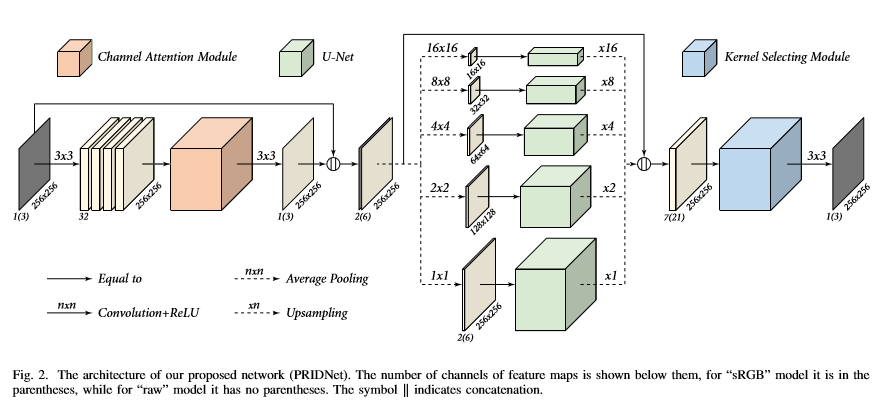

In the research paper, they have used 320 clean-noisy image pairs from SIDD dataset for training the model. They trained the model for 4000 epochs, where the learning rate for the ﬁrst 1500 epochs is 10e−4, and then 10e−5 to ﬁnetune the model.  <br>
Refer the research paper for detailed explanation : https://arxiv.org/pdf/1908.00273v2.pdf

Modifications on PRIDNet implementation compared to the research paper.<br>
1. In addition to SIDD Dataset, 221 clean-noisy image pairs from RENOIR Dataset is also used for training. 

2. Training for 4000 epochs wont be feasilble. Will try to get the best performance within the limitations of system configurations.

##Noise Estimation Stage

In [36]:
#https://github.com/491506870/PRIDNet/blob/master/network.py
class convolutional_block1(tf.keras.layers.Layer):
    def __init__(self,filters,**kwargs):
        super().__init__(**kwargs)
        self.filters = filters 
        self.conv1 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv3 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv4 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')

    def get_config(self):
      config = super().get_config().copy()
      config.update({'filters': self.filters})
      return config

    def call(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        return X

In [37]:
class CAM(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.gap = GlobalAveragePooling2D()
    self.dense1 = Dense(units=2,activation='relu')
    self.dense2 = Dense(units=32,activation='sigmoid')

  def call(self, X):
    Y = self.gap(X)
    Y = self.dense1(Y)
    Y = self.dense2(Y)
    X = Multiply()([X,Y])
    return X

##Multi Stage Denoising

In [38]:
class convolutional_block2(tf.keras.layers.Layer):
    def __init__(self,filters,**kwargs):
        super().__init__(**kwargs)
        self.filters = filters 
        self.conv1 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv3 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')

    def get_config(self):
        config = super().get_config().copy()
        config.update({'filters': self.filters})
        return config

    def call(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        return X

In [39]:
class pyramid(tf.keras.layers.Layer):
  def __init__(self,pool_size, upsample_size, **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size
    self.upsample_size = upsample_size
    self.upsample = UpSampling2D(self.upsample_size, interpolation='bilinear')
    self.pool = AveragePooling2D(pool_size=(self.pool_size,self.pool_size))
    
    self.conv1 = convolutional_block1(filters=32)
    self.maxpool1 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv2 = convolutional_block1(filters=64)
    self.maxpool2 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv3 = convolutional_block1(filters=128)
    self.maxpool3 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv4 = convolutional_block1(filters=256)
    self.maxpool4 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv5 = convolutional_block1(filters=512)
    
    self.upsample1 = Conv2DTranspose(256, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv6 = convolutional_block2(filters=256)

    self.upsample2 = Conv2DTranspose(128, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv7 = convolutional_block2(filters=128)
    
    self.upsample3 = Conv2DTranspose(64, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv8 = convolutional_block2(filters=64)

    self.upsample4 = Conv2DTranspose(32, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv9 = convolutional_block2(filters=32)

    self.conv10 = Conv2D(filters = 3, kernel_size=1,padding='same',kernel_initializer='he_normal')

  def get_config(self):
    config = super().get_config().copy()
    config.update({'pool_size': self.pool_size,'upsample_size':self.upsample_size})
    return config

  def call(self, input):
    conv1 = self.pool(input)
    
    conv1 = self.conv1(conv1)
    pool1 = self.maxpool1(conv1)
    
    conv2 = self.conv2(pool1)
    pool2 = self.maxpool2(conv2)

    conv3 = self.conv3(pool2)
    pool3 = self.maxpool3(conv3)

    conv4 = self.conv4(pool3)
    pool4 = self.maxpool4(conv4)

    conv5 = self.conv5(pool4)

    up1 = self.upsample1(conv5)
    concat1 = concatenate([up1,conv4])
    conv6 = self.conv6(concat1)

    up2 = self.upsample2(conv6)    
    concat2 = concatenate([up2,conv3])
    conv7 = self.conv7(concat2)


    up3 = self.upsample3(conv7)
    concat3 = concatenate([up3,conv2])
    conv8 = self.conv8(concat3)

    up4 = self.upsample4(conv8)
    concat4 = concatenate([up4,conv1])
    conv9 = self.conv9(concat4)
 
    conv10 = self.conv10(conv9)
    out = self.upsample(conv10)

    return out

##Feature Fusion Stage

In [40]:
class KSM(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.conv1 = Conv2D(filters = 21, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
    self.conv2 = Conv2D(filters = 21, kernel_size=5,activation='relu',padding='same',kernel_initializer='he_normal')
    self.conv3 = Conv2D(filters = 21, kernel_size=7,activation='relu',padding='same',kernel_initializer='he_normal')
    self.gap = GlobalAveragePooling2D()
    self.fc1 = Dense(units=2,activation='relu')
    self.fc2_1 = Dense(units=21)
    self.fc2_2 = Dense(units=21)
    self.fc2_3 = Dense(units=21)

  def call(self, input):
    conv1 = self.conv1(input)
    conv2 = self.conv2(input)
    conv3 = self.conv3(input)
    sum = Add()([conv1,conv2,conv3])
    gap =  self.gap(sum)
    gap = tf.reshape(gap, [-1, 1, 1, 21])
    fc1 = self.fc1(gap)
    a1 = self.fc2_1(fc1)
    a2 = self.fc2_2(fc1)
    a3 = self.fc2_3(fc1)

    before_softmax = concatenate([a1, a2, a3],1)
    after_softmax = softmax(before_softmax,axis=1)

    a1 = after_softmax[:, 0, :, :]
    a1 = tf.reshape(a1, [-1, 1, 1, 21])

    a2 = after_softmax[:, 1, :, :]
    a2 = tf.reshape(a2, [-1, 1, 1, 21])

    a3 = after_softmax[:, 2, :, :]
    a3 = tf.reshape(a3, [-1, 1, 1, 21])

    out1 = Multiply()([a1,conv1])
    out2 = Multiply()([a2,conv2])
    out3 = Multiply()([a3,conv3])
    out = Add()([out1,out2,out3])
    return out                      

##Model Creation

In [41]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

C1 = convolutional_block1(filters=32)(input)
cam = CAM()(C1)
C2 = Conv2D(filters = 3, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')(cam)
concat1 = concatenate([C2,input])

p1 = pyramid(pool_size=1,upsample_size=1)(concat1)
p2 = pyramid(pool_size=2,upsample_size=2)(concat1)
p3 = pyramid(pool_size=4,upsample_size=4)(concat1)
p4 = pyramid(pool_size=8,upsample_size=8)(concat1)
p5 = pyramid(pool_size=16,upsample_size=16)(concat1)

concat2 = concatenate([p1,p2,p3,p4,p5,concat1])
ksm = KSM()(concat2)
out = Conv2D(filters = 3, kernel_size=1,padding='same',kernel_initializer='he_normal')(ksm)

PRIDNet = Model(input,out)
PRIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
PRIDNet.summary()


2023-02-09 13:56:33.963500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:56:34.080245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:56:34.081289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 13:56:34.094390: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
convolutional_block1 (convoluti (None, 256, 256, 32) 28640       input_1[0][0]                    
__________________________________________________________________________________________________
cam (CAM)                       (None, 256, 256, 32) 162         convolutional_block1[0][0]       
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 3)  867         cam[0][0]                        
______________________________________________________________________________________________

In [ ]:
log_dir="logs/model_3"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=3,min_delta=0.00001)
callback = [tensorboard,reducelr]
PRIDNet.fit(train_dataloader,shuffle=True,epochs=30,validation_data= test_dataloader,callbacks=callback)

2023-02-09 13:56:39.299523: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-09 13:56:39.299567: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-02-09 13:56:39.306062: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-02-09 13:56:39.503684: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-09 13:56:39.503934: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-02-09 13:56:39.989463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2023-02-09 13:56:51.031055: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/88 [..............................] - ETA: 37:34 - loss: 0.0913

2023-02-09 13:57:06.445973: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-02-09 13:57:06.446033: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/88 [..............................] - ETA: 2:17 - loss: 7.8180 

2023-02-09 13:57:07.746311: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-02-09 13:57:07.751957: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-02-09 13:57:07.932252: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5189 callback api events and 5187 activity events. 
2023-02-09 13:57:08.057907: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-02-09 13:57:08.225535: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/model_3/train/plugins/profile/2023_02_09_13_57_08

2023-02-09 13:57:08.327625: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/model_3/train/plugins/profile/2023_02_09_13_57_08/177c971a57f6.trace.json.gz
2023-02-09 13:57:08.498642: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating director

88/88 [==============================] - 113s 997ms/step - loss: 0.1949 - val_loss: 0.0025


2023-02-09 13:58:32.971527: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 35389440 exceeds 10% of free system memory.
2023-02-09 13:58:33.004168: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 70778880 exceeds 10% of free system memory.
2023-02-09 13:58:33.061808: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 70778880 exceeds 10% of free system memory.
2023-02-09 13:58:33.118087: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 70778880 exceeds 10% of free system memory.
2023-02-09 13:58:33.180776: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 141557760 exceeds 10% of free system memory.


Epoch 2/30
88/88 [==============================] - 89s 1s/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/30
88/88 [==============================] - 84s 954ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/30
88/88 [==============================] - 84s 953ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/30
88/88 [==============================] - 84s 955ms/step - loss: 0.0011 - val_loss: 9.9426e-04
Epoch 6/30
88/88 [==============================] - 84s 954ms/step - loss: 9.6312e-04 - val_loss: 0.0011
Epoch 7/30
88/88 [==============================] - 84s 953ms/step - loss: 9.4450e-04 - val_loss: 9.7091e-04
Epoch 8/30
88/88 [==============================] - 84s 952ms/step - loss: 9.1828e-04 - val_loss: 9.3876e-04
Epoch 9/30
88/88 [==============================] - 89s 1s/step - loss: 8.5374e-04 - val_loss: 8.7312e-04
Epoch 10/30
88/88 [==============================] - 84s 953ms/step - loss: 8.9192e-04 - val_loss: 8.2047e-04
Epoch 11/30
88/88 [==============================] - 84s

In [ ]:
%tensorboard --logdir "/content/logs/model_3"

In [ ]:
PRIDNet.save('PRIDNet.h5')

In [ ]:
PRIDNet = tf.keras.models.load_model('/kaggle/working/PRIDNet.h5',custom_objects={'convolutional_block1':convolutional_block1, 'CAM':CAM,'convolutional_block2':convolutional_block2,'pyramid':pyramid,'KSM':KSM})

In [ ]:
sample

In [ ]:
df

In [ ]:
sample = pd.DataFrame({'Ground Truth Images' :['/kaggle/input/renoir/GroundTruth/29.bmp','/kaggle/input/renoir/GroundTruth/84.bmp','/kaggle/input/renoir/GroundTruth/18.bmp'], "Noisy Images" : ['/kaggle/input/renoir/GroundTruth/29.bmp','/kaggle/input/renoir/GroundTruth/84.bmp','/kaggle/input/renoir/GroundTruth/18.bmp']})
sample

In [ ]:
visualize(sample,PRIDNet)

In [ ]:
X_train, y_train = pickle.load(open('/kaggle/working/train_data.pkl', 'rb'))
X_test,y_test = pickle.load(open('/kaggle/working/test_data.pkl', 'rb'))

In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,PRIDNet)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

In [ ]:
model_size = round((os.stat('/kaggle/working/PRIDNet.h5').st_size)/(1024**2),3)
PSNR.append(round(psnr_de_nsy,3))
SSIM.append(round(ssim_de_nsy,3))
PSNR_imp.append(round(psnr_de_nsy-psnr_nsy,3))
SSIM_imp.append(round(ssim_de_nsy-ssim_nsy,3))
size.append(model_size)